In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [34]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [33]:
#build dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0]  * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [35]:
#MLP revisited
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator = g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g)
b1 = torch.randn(n_hidden,                        generator = g)
W2 = torch.randn((n_hidden, vocab_size),          generator = g)
b2 = torch.randn(vocab_size,                      generator = g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [37]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_size):
    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0: #print once a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 27.8382
  10000/ 200000: 2.5204
  20000/ 200000: 2.4153
  30000/ 200000: 2.5234
  40000/ 200000: 2.9007
  50000/ 200000: 2.3384
  60000/ 200000: 2.3682
  70000/ 200000: 2.0098
  80000/ 200000: 2.1833
  90000/ 200000: 2.4409
 100000/ 200000: 2.5942
 110000/ 200000: 1.8731
 120000/ 200000: 2.4312
 130000/ 200000: 2.1766
 140000/ 200000: 2.0140
 150000/ 200000: 2.3083
 160000/ 200000: 1.9800
 170000/ 200000: 2.1981
 180000/ 200000: 2.2275
 190000/ 200000: 1.9139


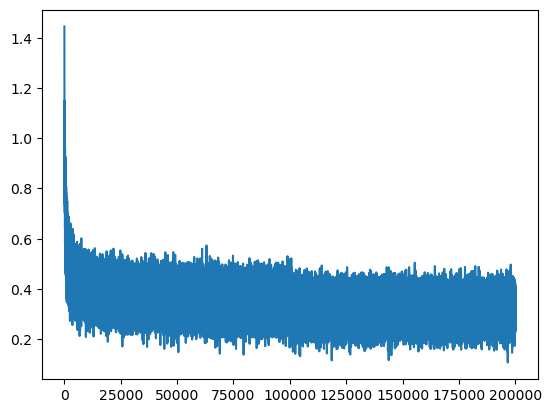

In [38]:
plt.plot(lossi)

In [42]:
@torch.no_grad()  #disables gradient tracking
def split_loss(split):
    x, y = {'train': (Xtr, Ytr), 
            'val': (Xdev, Ydev), 
            'test': (Xte, Yte)}[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1191043853759766
val 2.1609528064727783
